In [9]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import os

# 1. Transition probabilities and rates
ν = 0.1  # base velocity
prob = dict(
    P0_P2=0.60, P2_P1=0.50, P1_P0=0.30,
    A0_A1=0.10, A1_A2=0.75, A2_A3=0.80,
    S0_S1=0.70, S1_S2=0.65,
    U0_U1=0.65, U1_U2=0.50, U2_U1=0.25, U1_U0=0.20,
    V0_V1=0.45, V1_V2=0.40, V2_V0=0.20,
    E0_E1=0.55, E1_E2=0.50, E2_E3=0.40,
    H0_H1=0.50, H1_H2=0.45, H2_H3=0.35, E3_H2=0.20
)
λ = {k: v * ν for k, v in prob.items()}

# 2. Indexing and initialization
idx = {s: i for i, s in enumerate([
    'P0', 'P1', 'P2', 'A0', 'A1', 'A2', 'A3',
    'S0', 'S1', 'S2', 'U0', 'U1', 'U2',
    'V0', 'V1', 'V2', 'E0', 'E1', 'E2', 'E3',
    'H0', 'H1', 'H2', 'H3'
])}
N = len(idx)
labels = list(idx.keys())

Π0 = np.zeros(N)
Π0 = np.zeros(N)

# Patient Devices
Π0[idx['P0']] = 100.   # Healthy devices
Π0[idx['P1']] = 0.
Π0[idx['P2']] = 0.

# Attackers
Π0[idx['A0']] = 1.
Π0[idx['A1']] = 0.
Π0[idx['A2']] = 0.
Π0[idx['A3']] = 0.

# Security System
Π0[idx['S0']] = 1.
Π0[idx['S1']] = 0.
Π0[idx['S2']] = 0.

# Operators
Π0[idx['U0']] = 1.
Π0[idx['U1']] = 0.
Π0[idx['U2']] = 0.

# Ventilators
Π0[idx['V0']] = 5.
Π0[idx['V1']] = 0.
Π0[idx['V2']] = 0.

# Edge Nodes
Π0[idx['E0']] = 3.
Π0[idx['E1']] = 0.
Π0[idx['E2']] = 0.
Π0[idx['E3']] = 0.

# Hospital Backend
Π0[idx['H0']] = 1.
Π0[idx['H1']] = 0.
Π0[idx['H2']] = 0.
Π0[idx['H3']] = 0.

# 3. ODE system
def rhs(t, P):
    d = np.zeros_like(P)
    P0, P1, P2 = P[idx['P0']], P[idx['P1']], P[idx['P2']]
    A0, A1, A2, A3 = P[idx['A0']], P[idx['A1']], P[idx['A2']], P[idx['A3']]
    S0, S1, S2 = P[idx['S0']], P[idx['S1']], P[idx['S2']]
    U0, U1, U2 = P[idx['U0']], P[idx['U1']], P[idx['U2']]
    V0, V1, V2 = P[idx['V0']], P[idx['V1']], P[idx['V2']]
    E0, E1, E2, E3 = P[idx['E0']], P[idx['E1']], P[idx['E2']], P[idx['E3']]
    H0, H1, H2, H3 = P[idx['H0']], P[idx['H1']], P[idx['H2']], P[idx['H3']]

    d[idx['P0']] = -λ['P0_P2'] * A3 * P0 + λ['P1_P0'] * P1
    d[idx['P2']] = λ['P0_P2'] * A3 * P0 - λ['P2_P1'] * S2 * P2
    d[idx['P1']] = λ['P2_P1'] * S2 * P2 - λ['P1_P0'] * P1

    d[idx['A0']] = -λ['A0_A1'] * A0
    d[idx['A1']] = λ['A0_A1'] * A0 - λ['A1_A2'] * A1
    d[idx['A2']] = λ['A1_A2'] * A1 - λ['A2_A3'] * A2
    d[idx['A3']] = λ['A2_A3'] * A2

    d[idx['S0']] = -λ['S0_S1'] * S0
    d[idx['S1']] = λ['S0_S1'] * S0 - λ['S1_S2'] * S1
    d[idx['S2']] = λ['S1_S2'] * S1

    d[idx['U0']] = -λ['U0_U1'] * U0 + λ['U1_U0'] * U1
    d[idx['U1']] = λ['U0_U1'] * U0 - (λ['U1_U2'] + λ['U1_U0']) * U1 + λ['U2_U1'] * U2
    d[idx['U2']] = λ['U1_U2'] * U1 - λ['U2_U1'] * U2

    d[idx['V0']] = -λ['V0_V1'] * V0
    d[idx['V1']] = λ['V0_V1'] * V0 - λ['V1_V2'] * V1
    d[idx['V2']] = λ['V1_V2'] * V1 - λ['V2_V0'] * V2

    d[idx['E0']] = -λ['E0_E1'] * E0
    d[idx['E1']] = λ['E0_E1'] * E0 - λ['E1_E2'] * E1
    d[idx['E2']] = λ['E1_E2'] * E1 - λ['E2_E3'] * E2
    d[idx['E3']] = λ['E2_E3'] * E2 - λ['E3_H2'] * E3 * H2

    d[idx['H0']] = -λ['H0_H1'] * H0
    d[idx['H1']] = λ['H0_H1'] * H0 - λ['H1_H2'] * H1
    d[idx['H2']] = λ['H1_H2'] * H1 - λ['H2_H3'] * H2 + λ['E3_H2'] * E3 * H2
    d[idx['H3']] = λ['H2_H3'] * H2

    return d

# 4. Integration
t_end = 150
t_grid = np.linspace(0, t_end, 301)
sol = solve_ivp(rhs, (0, t_end), Π0, t_eval=t_grid, rtol=1e-8, atol=1e-10)

# 5. Plotting
slc = dict(
    P=slice(idx['P0'], idx['P2']+1),
    A=slice(idx['A0'], idx['A3']+1),
    S=slice(idx['S0'], idx['S2']+1),
    U=slice(idx['U0'], idx['U2']+1),
    V=slice(idx['V0'], idx['V2']+1),
    E=slice(idx['E0'], idx['E3']+1),
    H=slice(idx['H0'], idx['H3']+1),
)

if not os.path.exists("plots"):
    os.makedirs("plots")

def save_plot_for_class(agent_class, sl, title):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(sol.t, sol.y[sl].T, lw=2)
    ax.set_title(title, fontsize=13)
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Population')
    ax.grid(alpha=.3)
    ax.legend([labels[i] for i in range(*sl.indices(N))], fontsize=8, loc='best')
    plt.tight_layout()
    plt.savefig(f"./plots/mam_{agent_class}_class.pdf", bbox_inches='tight')
    plt.close()

for agent, title in zip(['P', 'A', 'S', 'U', 'V', 'E', 'H'],
                        ['Patient devices (P-class)', 'Attackers (A-class)', 'Security module (S-class)',
                         'Operators (U-class)', 'Ventilators (V-class)', 'Edge nodes (E-class)', 'Hospital backend (H-class)']):
    save_plot_for_class(agent, slc[agent], title)


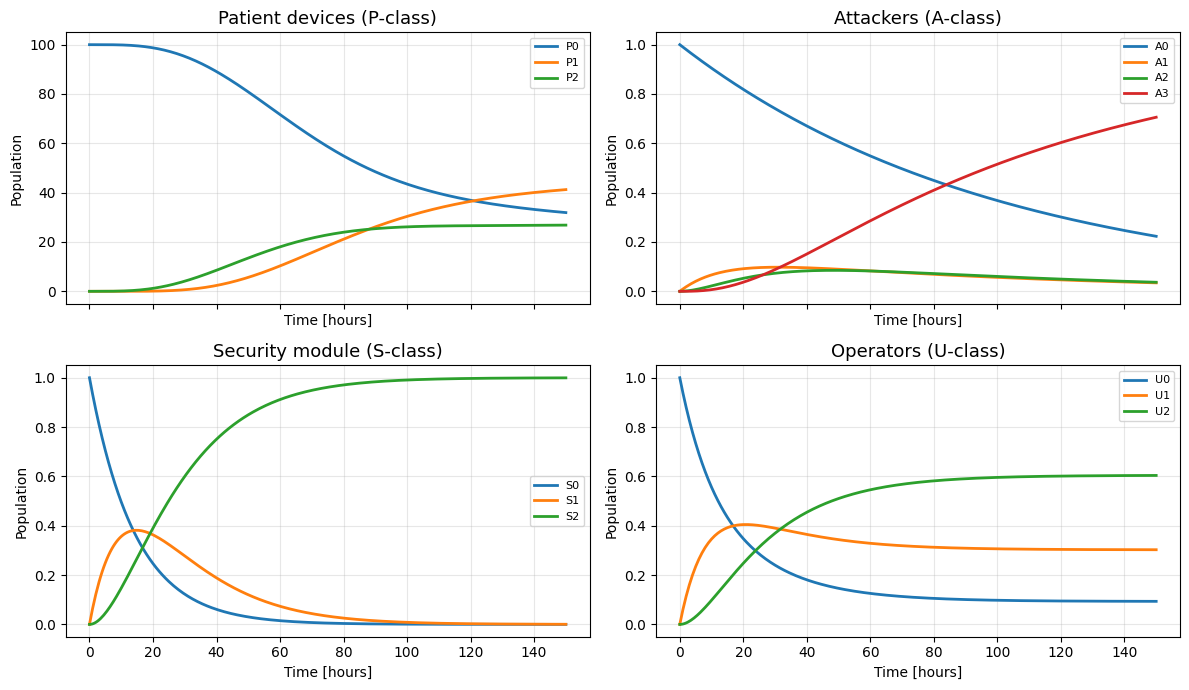

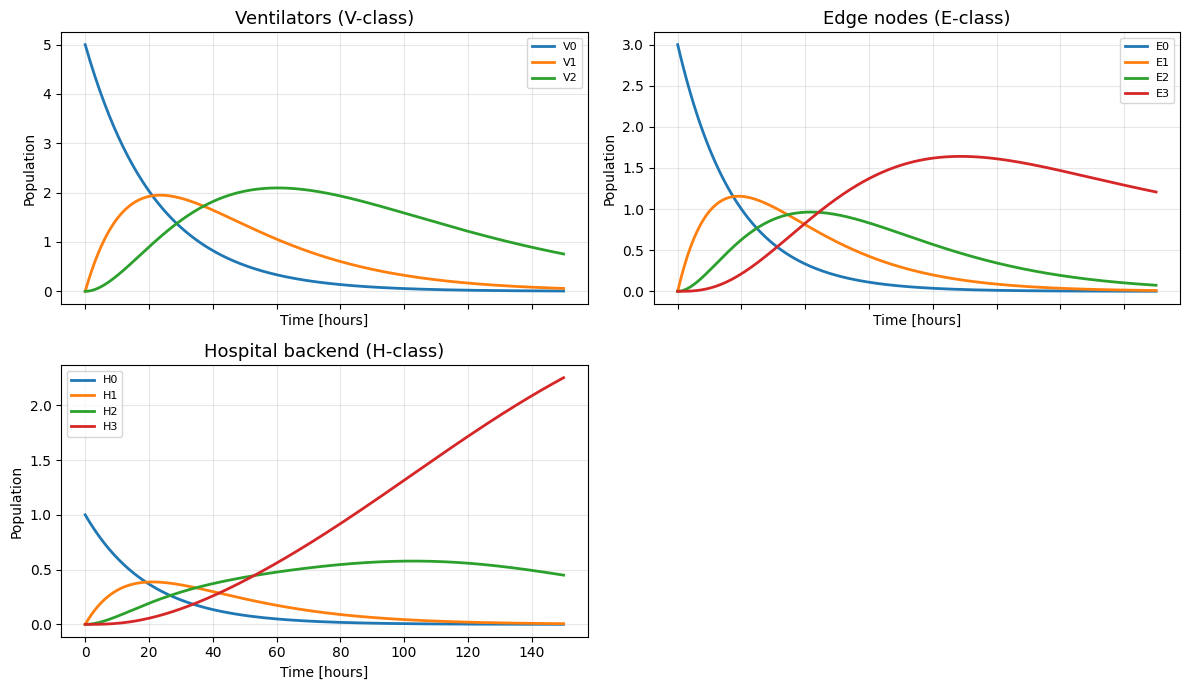

In [15]:

def subplot(ax, sl, title):
    ax.plot(sol.t, sol.y[sl].T, lw=2)
    ax.set_title(title, fontsize=13)
    ax.set_xlabel('Time [hours]')
    ax.set_ylabel('Population')
    ax.grid(alpha=.3)
    ax.legend([labels[i] for i in range(*sl.indices(N))], fontsize=8, loc='best')

# ----------- Figure 1: P, A, S, U ------------------
fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 7), sharex=True)

subplot(ax1, slc['P'], 'Patient devices (P-class)')
subplot(ax2, slc['A'], 'Attackers (A-class)')
subplot(ax3, slc['S'], 'Security module (S-class)')
subplot(ax4, slc['U'], 'Operators (U-class)')

fig1.tight_layout()
fig1.savefig("./plots/mam_panel_1.pdf", bbox_inches='tight')



# ----------- Figure 2: V, E, H (in 2x2 layout) ------------------
fig2, axs = plt.subplots(2, 2, figsize=(12, 7), sharex=True)

subplot(axs[0][0], slc['V'], 'Ventilators (V-class)')
subplot(axs[0][1], slc['E'], 'Edge nodes (E-class)')
subplot(axs[1][0], slc['H'], 'Hospital backend (H-class)')

# Hide the unused subplot (bottom-right corner)
fig2.delaxes(axs[1][1])

fig2.tight_layout()
fig2.savefig("./plots/mam_panel_2.pdf", bbox_inches='tight')
plt.show()



